#### Cell 1
Contains all the import statements needed for this project

In [1]:
#Cell 1
#All the imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Dataset Import and Exploration

The following cells contains the code to import the dataset using glob API and display the useful information about dataset along with plots of car and non-car image

In [2]:
#Cell 2
#Import Dataset

cars = []
notcars = []

images = glob.glob('vehicles/GTI_Far/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('vehicles/GTI_Left/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('vehicles/GTI_MiddleClose/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('vehicles/GTI_Right/*.png')
for image in images:
        cars.append(image)

images = glob.glob('vehicles/KITTI_extracted/*.png')
for image in images:
        cars.append(image)
        
print("The total images in the car dataset are:",len(cars))

images = glob.glob('non-vehicles/Extras/*.png')
for image in images:
        notcars.append(image)

images = glob.glob('non-vehicles/GTI/*.png')
for image in images:
        notcars.append(image)
        
print("The total images in the car dataset are:",len(notcars))

The total images in the car dataset are: 8792
The total images in the car dataset are: 8968


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


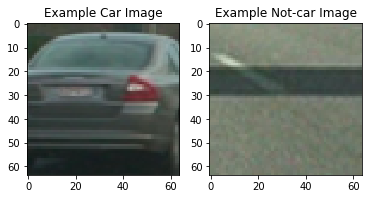

In [37]:
#Cell 3
#Dataset exploration

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
fig.savefig('output_images/data_look.jpg')

# Feature Extraction for Car Detection

The following code cells contains various methods helpful for feature extraction of images to classify them as car or non-car images. The methods defined below uses Spatial binning, Color Histogram and Histogram of Oriented Gradient (HOG) approaches for feature extraction.

**Spatial Binning**: The purpose of Spatial Binning is to combine multiple pixels into a single pixel in order to reduce image size while also preserving the useful information from the image data. The default size for spatial binning is kept as 32 x 32 pixel and np.ravel() function is used to flatten the image features into a single array.

**Color Histogram**: As mentioned in the classroom lectures as well as observed from personal experience, the car is reach in its color compared to the background information in an image. Thus having a color histogram of Car in HSV or similar color space can be very useful to detect car among the other information in the image data. This is achieved through the color_hist method declared below which basically generates the histogram of colors which can be used as feature for training the classifier.

**HOG Feature**: Gradients of an image consist a very critical information about the changes in intensities along the edges of objects in an image. This becomes very useful to detect shapes in image data. When we consider Histogram of Gradients instead of just pure gradient magnitude or direction, it becomes a more robust feature and can be used on classifier for training.

In [4]:
#Cell 4
#Feature functions

# Spatial Binning
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Histogram of Colors
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Histogram of Gradients
# Define a function to return HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

## Spatial Binning and Color Histogram Visualization

The following two cells gives the visualization of Spatial Binning and Color Histogram Visualization techniques which are used for feature extraction from the input data.

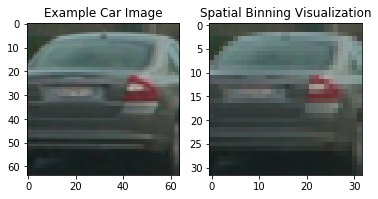

In [38]:
#Cell 5

#Spatial Binning Visualization

image = mpimg.imread(cars[car_ind])
spatial_binning_img = cv2.resize(image, (32,32))
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(spatial_binning_img, cmap='gray')

plt.title('Spatial Binning Visualization')
fig.savefig('output_images/spatial_binning.jpg')

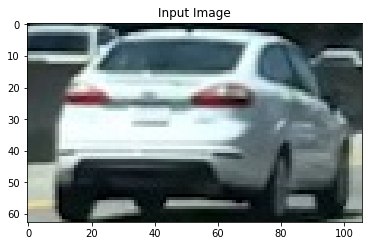

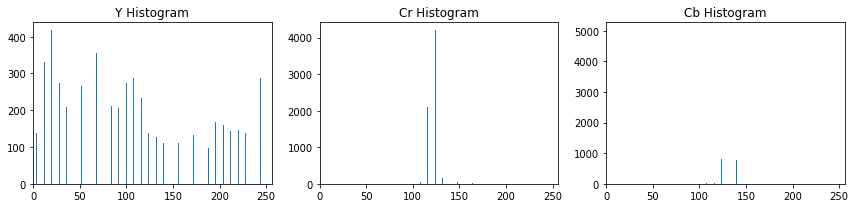

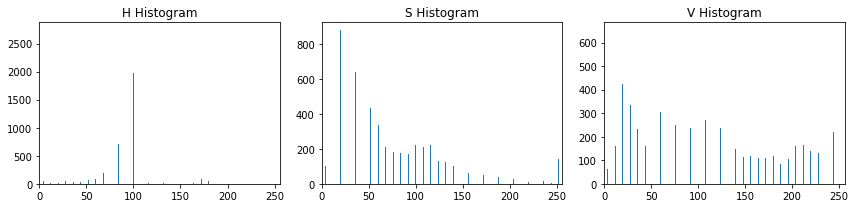

In [39]:
#Cell 6

#Color Histogram Visualization

image = mpimg.imread("cutout1.jpg")
plt.title('Input Image')
plt.imshow(image, cmap='gray')

feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
channel0_hist = np.histogram(feature_image[:,:,0], bins=32, range=(0, 256))
channel1_hist = np.histogram(feature_image[:,:,1], bins=32, range=(0, 256))
channel2_hist = np.histogram(feature_image[:,:,2], bins=32, range=(0, 256))
# Generating bin centers
bin_edges = channel0_hist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
if channel0_hist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, channel0_hist[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    fig.savefig('output_images/YCrCb_color_hist.jpg')
else:
    print('Your function is returning None for at least one variable...')

feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
channel0_hist = np.histogram(feature_image[:,:,0], bins=32, range=(0, 256))
channel1_hist = np.histogram(feature_image[:,:,1], bins=32, range=(0, 256))
channel2_hist = np.histogram(feature_image[:,:,2], bins=32, range=(0, 256))
# Generating bin centers
bin_edges = channel0_hist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2    

# Plot a figure with all three bar charts
if channel0_hist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, channel0_hist[0])
    plt.xlim(0, 256)
    plt.title('H Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
    fig.savefig('output_images/HSV_color_hist.jpg')
else:
    print('Your function is returning None for at least one variable...')


### HOG Visualization

The following code cell can be used to visualize the Histogram of Oriented Gradients on any image. It leverages the function `get_hog_features()` defined above to to obtain the HOG for a given image and displays the input image and HOG using pyplot of Matplotlib.

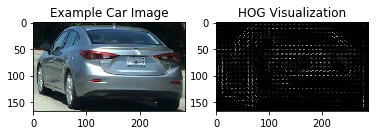

In [40]:
#Cell 7

# HOG Visualization
# Read in the image
image = mpimg.imread("cutout6.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.savefig('output_images/HOG_visualization.jpg')

### Feature Extraction

For feature extraction purposes, the following methods are defined:

**`extract_features()`:** This method extracts useful features from the image data using spatial binning, color histogram and HOG for all the images of car and non-car dataset. This method will be used to extract the features of training data and then train the classifier using the features returned by this.

**`single_img_features()`:** This method is similar to extract_features method except that it works on a single image and can be used for test image and training pipeline.

**`get_features()`**: This method has the call to extract_features() method with training data and it can be used to change various parameters of feature extraction by passing the parameters as arguments to this method.

In [8]:
#Cell 8
#Feature Extraction Functions

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def get_features(color_space = 'YCrCb', orient = 9, pix_per_cell = 8, cell_per_block = 2, 
                 hog_channel = "ALL", spatial_size = (16, 16), hist_bins = 16, spatial_feat = True, 
                 hist_feat = True, hog_feat = True, bins_range=(0,1)):
    
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return car_features, notcar_features

In [28]:
#Cell 9
#Parameter Tweaking for Feature extraction

# Generate all the features of training dataset
xy_overlap = (0.8, 0.8)
xy_window = [64,64]
y_start_stop = [340, 680] # Min and max in y to search in slide_window()
x_start_stop = [760, 1260]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [10]:
#Cell 10
#Extracting Features

car_features, notcar_features = get_features(color_space, orient, pix_per_cell, cell_per_block,
                                             hog_channel, spatial_size, hist_bins, spatial_feat,
                                             hist_feat, hog_feat)

### Feature Visualization

The following cell plots the features of one particular car image in Raw as well as Normalized form.

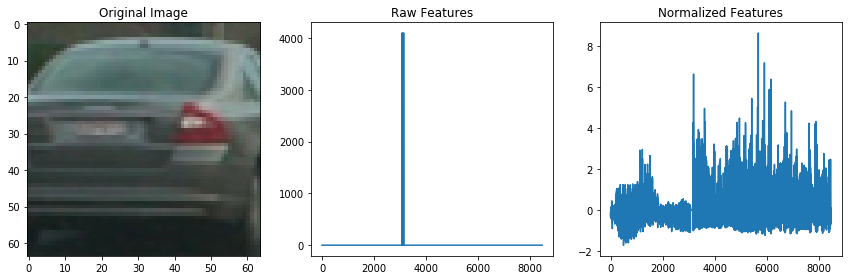

In [41]:
#Cell 11
#Display of extracted features
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    fig.savefig('output_images/raw_and_normalized_features.jpg')
else: 
    print('Your function only returns empty feature vectors...')

## Training SVM Classifer

For the purposes of Vehicle classification, SVM (Support Vector Machine) Classifier is used. The following cell contains the code to train the classifier using features of car and non-car image data. It uses sklearn's `train_test_split()` function in order to generate the test data from training data itself for the purposes of validation. The function also contains `time()` function in order to compute the time required for training and testing the classifier. It also computes and displays the accuracy achieved.

In [12]:
#Cell 12
#SVM Classifier Training

def train_classifier(car_features, notcar_features, spatial_size, hist_bins):
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial_size,
          'and', hist_bins,'histogram bins')
    print('Feature vector length:', len(X_train[0]))

    svc = LinearSVC()

    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

svc = train_classifier(car_features, notcar_features, spatial_size, hist_bins)

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
217.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
0.9048 Seconds to predict 10 labels with SVC


## Sliding Window and Search

The following cells contains the code to consider Sliding window method instead of entire image. The idea here is to reduce the overhead of compute by passing a portion of image data to the classifier and getting the predictions instead of the entire image. This is a very obvious thing to do as we know that our dashcam video feed will have cars in some portion of the screen and not entire screen / image.



In [29]:
#Cell 13
#Car Search

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def average_slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(32, 32), xy_overlap=(0.5, 0.5)):
    windows = []
    for xy in [64, 96, 140]:
        window = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(xy, xy), xy_overlap=xy_overlap)
        windows += window
    return windows

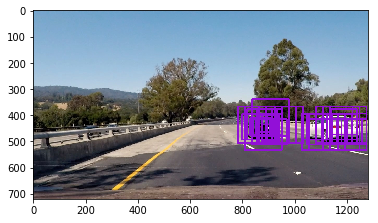

In [30]:
#Cell 14

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = mpimg.imread('test4.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

windows = average_slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                xy_window=(80, 80), xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(110, 240, 41), thick=6)                    

plt.imshow(window_img)
plt.imsave("final_window_img.jpg", window_img)

In [16]:
#Cell 15
#Heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,50,255), 6)
    # Return the image
    return img

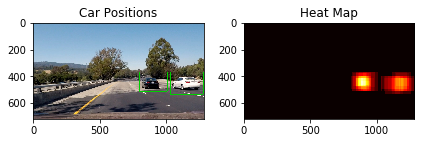

In [31]:
#Cell 16
#Heat Map and final result

from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heatmap = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
# heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.imsave("final_draw_img.jpg", draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [32]:
#Cell 17
#Video Pipeline

def processing_pipeline(img):
    image_copy = np.copy(img)
    image_copy = image_copy.astype(np.float32)/255
    draw_image = np.copy(image_copy)

    windows = average_slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                    xy_window=(80, 80), xy_overlap=(0.8, 0.8))

    hot_windows = search_windows(image_copy, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(110, 240, 41), thick=6)

    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heatmap = apply_threshold(heat,1)
    #heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)    
    return result

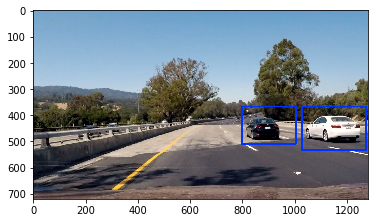

In [33]:
#Cell 18
#TO test the pipeline

image = mpimg.imread('test4.jpg')
result = processing_pipeline(image)
plt.imshow(result)

In [34]:
#Cell 19
#Video Processing

from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_processed = 'project_video_processed_R2.mp4'
video = VideoFileClip("./project_video.mp4", audio=False)
processed_clip = video.fl_image(processing_pipeline) #NOTE: this function expects color images!!
processed_clip.write_videofile(project_video_processed, audio=False)

[MoviePy] >>>> Building video project_video_processed_R2.mp4
[MoviePy] Writing video project_video_processed_R2.mp4


100%|██████████████████████████████████████████████████████▉| 1260/1261 [13:05:30<00:31, 31.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed_R2.mp4 



In [42]:
#Cell 20
#Video Display

project_video_processed = 'project_video_processed_R2.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_processed))